In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
from fab.learnt_distributions.real_nvp import make_realnvp_dist_funcs
from fab.target_distributions.many_well import DoubleWellEnergy
from fab.agent.fab_agent import AgentFAB
from fab.agent.bbb_agent import AgentBBB
from fab.agent.target_samples_agent import AgentTargetSamples
from fab.utils.plotting import plot_history, plot_marginal_pair, plot_contours_2D
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp

2022-04-20 10:59:49.447354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
dim = 2
flow_num_layers = 10
mlp_hidden_size_per_x_dim = 5
layer_norm = False
act_norm = True

## FAB agent

In [4]:
real_nvp_flo = make_realnvp_dist_funcs(dim, flow_num_layers,
                                       mlp_hidden_size_per_x_dim=mlp_hidden_size_per_x_dim,
                                      layer_norm=layer_norm, act_norm=act_norm)
target_log_prob = DoubleWellEnergy(dim=dim).log_prob
batch_size = 32
eval_batch_size = batch_size
n_evals = 10
n_iter = int(3e3)
lr = 5e-4
n_intermediate_distributions: int = 2
AIS_kwargs = {"transition_operator_type": "hmc_tfp"} 
optimizer = optax.chain(optax.zero_nans(), optax.adam(lr))
loss_type = "alpha_2_div"
style = "vanilla"

In [ ]:
n_target_evals = n_intermediate_distributions * n_iter * batch_size * 

In [5]:
def plotter(fab_agent, log_prob_2D=target_log_prob):
    batch_size = 100
    if style == "proptoloss":
        target_name = "p^2/q"
    else:
        target_name = "p"

    @jax.jit
    def get_info(state):
        base_log_prob = fab_agent.get_base_log_prob(state.learnt_distribution_params)
        target_log_prob = fab_agent.get_target_log_prob(state.learnt_distribution_params)
        x_base, log_q_x_base = fab_agent.learnt_distribution.sample_and_log_prob.apply(
            state.learnt_distribution_params, rng=state.key,
            sample_shape=(batch_size,))
        x_ais_loss, _, _, _ = \
            fab_agent.annealed_importance_sampler.run(
                x_base, log_q_x_base, state.key,
                state.transition_operator_state,
                base_log_prob=base_log_prob,
                target_log_prob=target_log_prob
            )
        return x_base, x_ais_loss

    x_base, x_ais_target = get_info(fab_agent.state)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plot_contours_2D(log_prob_2D, ax=axs[0], bound=3, levels=20)
    plot_marginal_pair(x_base, ax=axs[0])
    axs[0].set_title("base samples")
    plot_contours_2D(log_prob_2D, ax=axs[1], bound=3, levels=20)
    plot_marginal_pair(x_ais_target, ax=axs[1])
    axs[1].set_title(f"ais samples with target of: {target_name}")
    plt.show()
    return [fig]

In [6]:
fab_agent = AgentFAB(learnt_distribution=real_nvp_flo,
                     target_log_prob=target_log_prob,
                     n_intermediate_distributions=n_intermediate_distributions,
                     AIS_kwargs=AIS_kwargs,
                     optimizer=optimizer,
                     plotter=plotter,
                     loss_type=loss_type,
                      style=style,)

using linear spacing as there is 2intermediate distribution


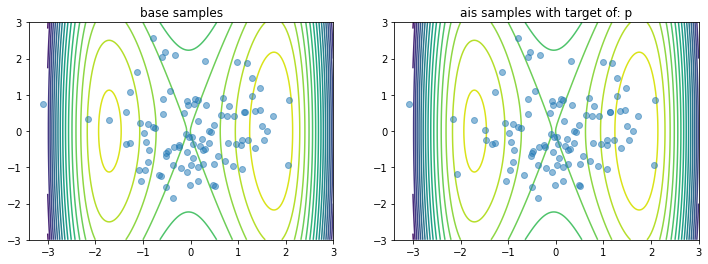

[<Figure size 864x288 with 2 Axes>]

In [7]:
plotter(fab_agent)

ess_ais: 0.1566869020462036, ess_base: 0.15563566982746124:   0%|                                                                                                                                     | 0/3000 [00:31<?, ?it/s]

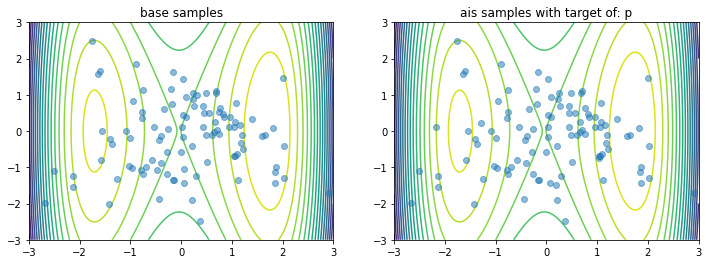

ess_ais: 0.5365797281265259, ess_base: 0.4606764614582062:  24%|█████████████████████████████▍                                                                                             | 718/3000 [00:56<00:08, 274.61it/s]

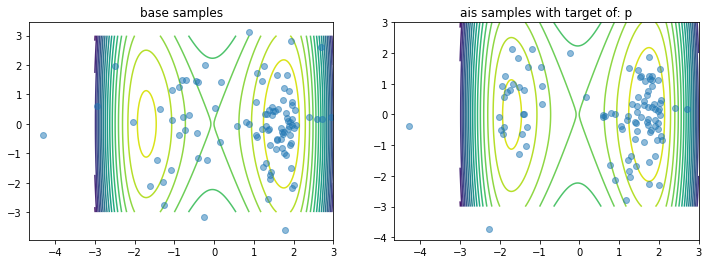

ess_ais: 0.3628126382827759, ess_base: 0.32748153805732727:  49%|███████████████████████████████████████████████████████████                                                              | 1465/3000 [01:08<00:03, 397.97it/s]

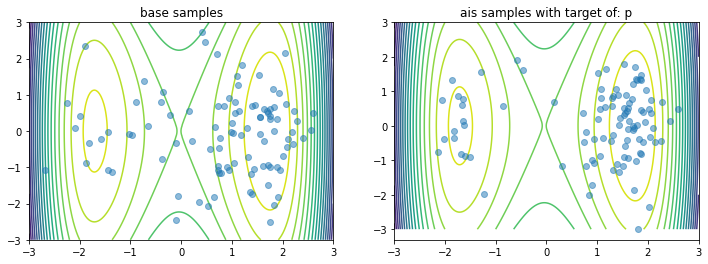

ess_ais: 0.4174290895462036, ess_base: 0.31440094113349915:  74%|█████████████████████████████████████████████████████████████████████████████████████████▏                               | 2210/3000 [01:20<00:02, 381.59it/s]

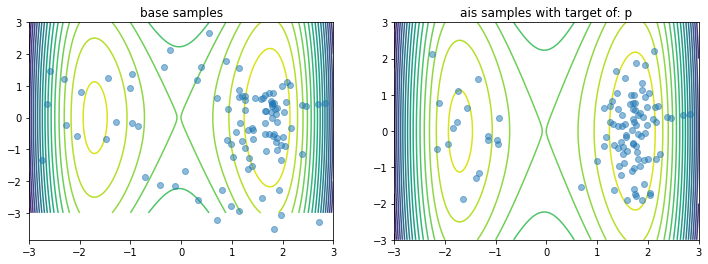

ess_ais: 0.7019319534301758, ess_base: 0.6085662841796875:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2957/3000 [01:32<00:00, 407.20it/s]

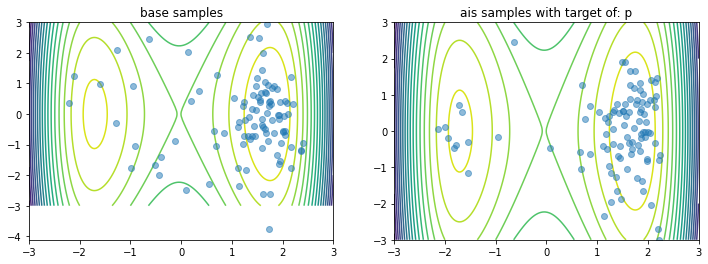

ess_ais: 0.7019319534301758, ess_base: 0.6085662841796875: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:43<00:00, 29.05it/s]


In [8]:
fab_agent.run(n_iter=n_iter, batch_size=batch_size, n_plots=5, n_evals=n_evals, eval_batch_size=eval_batch_size)

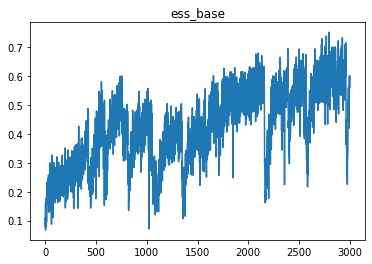

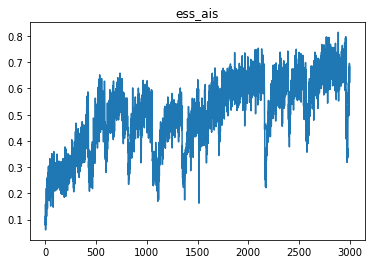

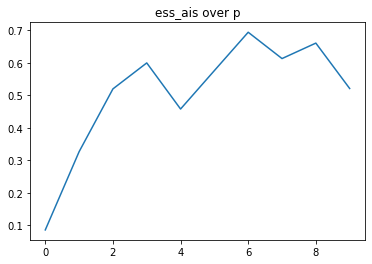

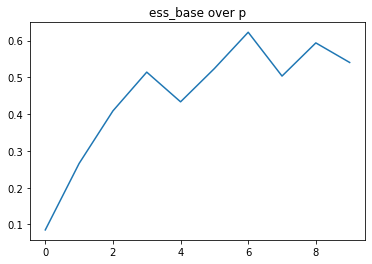

In [11]:
plt.plot(fab_agent.logger.history["ess_base"])
plt.title("ess_base")
plt.show()
plt.plot(fab_agent.logger.history["ess_ais"])
plt.title("ess_ais")
plt.show()
plt.plot(fab_agent.logger.history['eval_ess_ais'])
plt.title("ess_ais over p")
plt.show()
plt.plot(fab_agent.logger.history['eval_ess_flow'])
plt.title("ess_base over p")
plt.show()

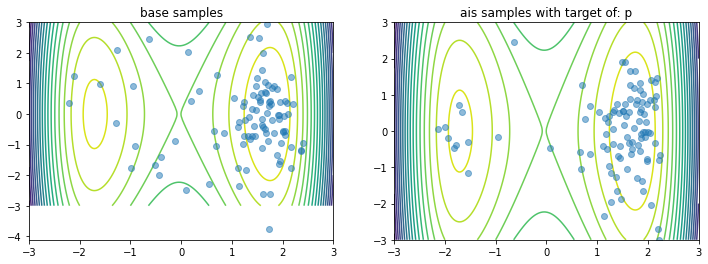

[<Figure size 864x288 with 2 Axes>]

In [12]:
plotter(fab_agent)

# Reverse-KL divergence agent

In [16]:
lr = 1e-4 # try with low lr to prevent mode seeking
real_nvp_flo = make_realnvp_dist_funcs(dim, flow_num_layers,
                                       mlp_hidden_size_per_x_dim=mlp_hidden_size_per_x_dim,
                                      layer_norm=layer_norm, act_norm=act_norm)
optimizer = optax.chain(optax.zero_nans(), optax.adam(lr))

In [17]:
bbb_agent = AgentBBB(learnt_distribution=real_nvp_flo,
                     target_log_prob=target_log_prob,
                     n_intermediate_distributions=n_intermediate_distributions,
                     AIS_kwargs=AIS_kwargs,
                     optimizer=optimizer,
                     plotter=plotter)

using linear spacing as there is 2intermediate distribution


  0%|                                                                                                                                                                                                 | 0/3000 [00:00<?, ?it/s]

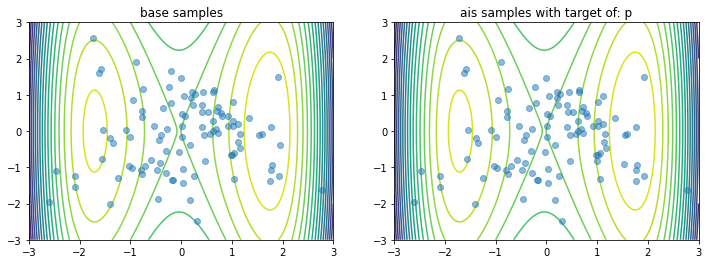

ess_ais: 0.23517875373363495, ess_base: 0.08236455172300339:  24%|█████████████████████████████▍                                                                                           | 731/3000 [00:55<00:08, 272.07it/s]

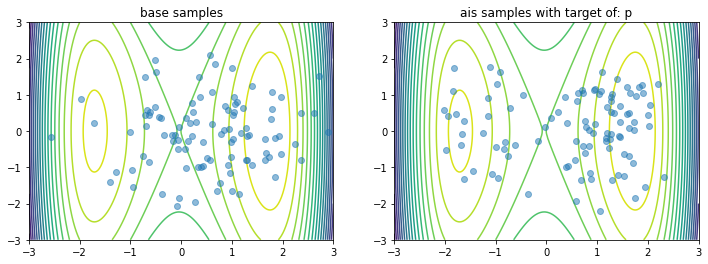

ess_ais: 0.8177570104598999, ess_base: 0.7291279435157776:  50%|████████████████████████████████████████████████████████████▌                                                             | 1489/3000 [01:08<00:05, 278.82it/s]

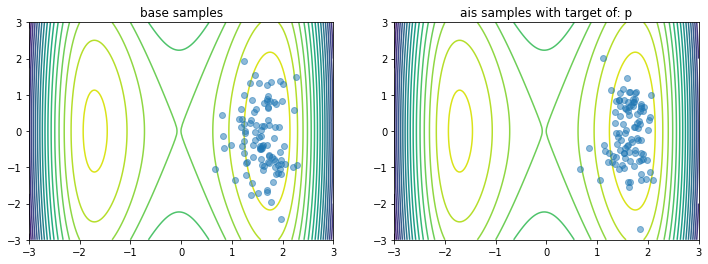

ess_ais: 0.9141494035720825, ess_base: 0.8960568308830261:  74%|██████████████████████████████████████████████████████████████████████████████████████████▌                               | 2228/3000 [01:21<00:02, 290.92it/s]

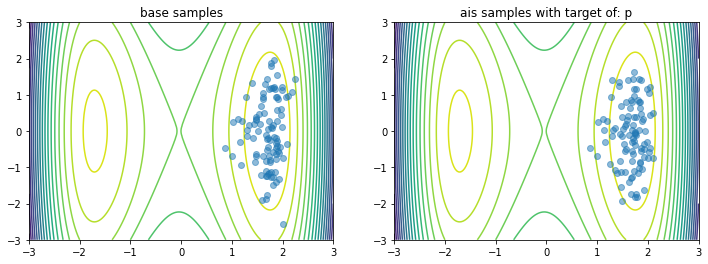

ess_ais: 0.7986515164375305, ess_base: 0.9784182906150818: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2998/3000 [01:35<00:00, 294.66it/s]

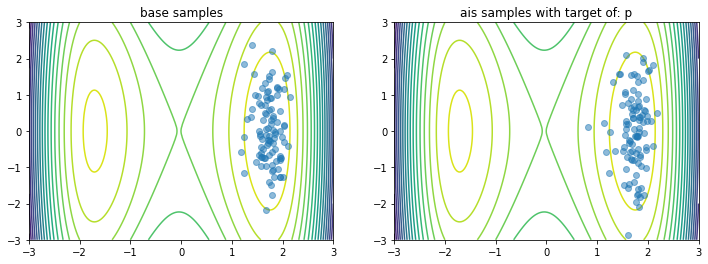

ess_ais: 0.7986515164375305, ess_base: 0.9784182906150818: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:47<00:00, 27.92it/s]


In [18]:
bbb_agent.run(n_iter=n_iter, batch_size=batch_size, n_plots=5, n_evals=n_evals, eval_batch_size=eval_batch_size)

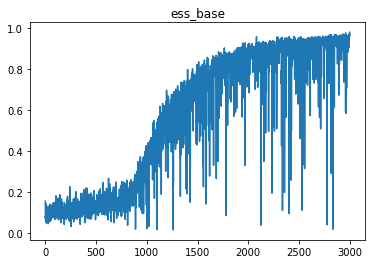

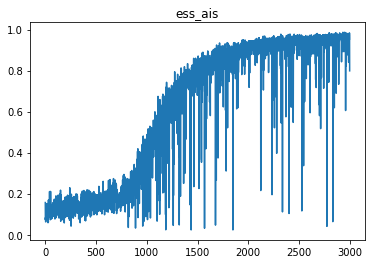

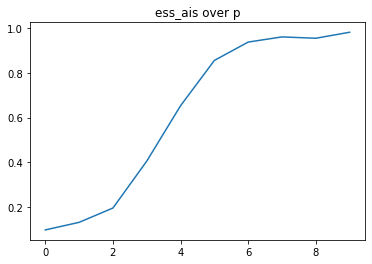

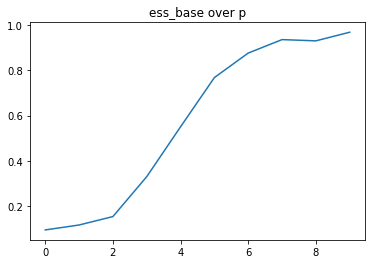

In [19]:
plt.plot(bbb_agent.logger.history["ess_base"])
plt.title("ess_base")
plt.show()
plt.plot(bbb_agent.logger.history["ess_ais"])
plt.title("ess_ais")
plt.show()
plt.plot(bbb_agent.logger.history['eval_ess_ais'])
plt.title("ess_ais over p")
plt.show()
plt.plot(bbb_agent.logger.history['eval_ess_flow'])
plt.title("ess_base over p")
plt.show()

# Target Samples Agent

In [6]:
lr = 5e-4
real_nvp_flo = make_realnvp_dist_funcs(dim, flow_num_layers,
                                       mlp_hidden_size_per_x_dim=mlp_hidden_size_per_x_dim,
                                      layer_norm=layer_norm, act_norm=act_norm)
optimizer = optax.chain(optax.zero_nans(), optax.adam(lr))

In [7]:
loss_type

'alpha_2_div'

In [9]:
target_samples_agent = AgentTargetSamples(
                     num_results=int(1e4), 
                     num_burnin_steps=int(1e3),
                     learnt_distribution=real_nvp_flo,
                     target_log_prob=target_log_prob,
                     n_intermediate_distributions=n_intermediate_distributions,
                     AIS_kwargs=AIS_kwargs,
                     optimizer=optimizer,
                     plotter=plotter,
)

using linear spacing as there is 2intermediate distribution
time to generate dataset: 0.022588578859965007  min


/home/meatrobot/miniconda3/envs/fabjax/lib/python3.8/site-packages/jax/_src/random.py:371: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


In [10]:
target_samples_agent.target_samples.shape

(10000, 2)

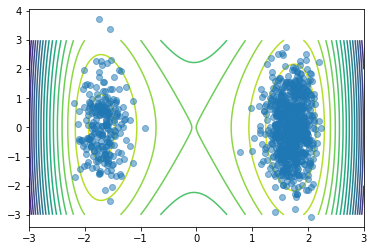

In [11]:
fig, ax = plt.subplots()
plot_contours_2D(target_log_prob, ax=ax, bound=3, levels=20)
plot_marginal_pair(target_samples_agent.target_samples[0:1000], ax=ax)
#plot_marginal_pair(target_samples_agent.target_samples[0:1000], ax=ax)
# plot_marginal_pair(target_samples_agent.target_samples[2000:3000], ax=ax)
#plot_marginal_pair(target_samples_agent.target_samples[5000:6000], ax=ax)
# plot_marginal_pair(target_samples_agent.target_samples[9000:10000], ax=ax)
# plot_marginal_pair(target_samples_agent.target_samples[9000:10000], ax=ax)

In [13]:
n_iter = 100 # 100 iterations through the dataset

ess_ais: 0.9261462092399597, ess_base: 0.9222179651260376:   0%|                                                                                                                                       | 0/100 [00:00<?, ?it/s]

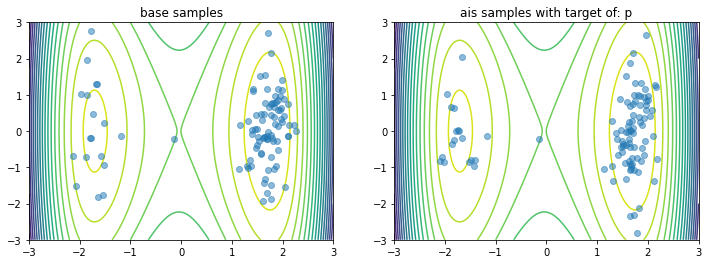

ess_ais: 0.9261462092399597, ess_base: 0.9222179651260376:  24%|██████████████████████████████▏                                                                                               | 24/100 [00:25<00:49,  1.53it/s]

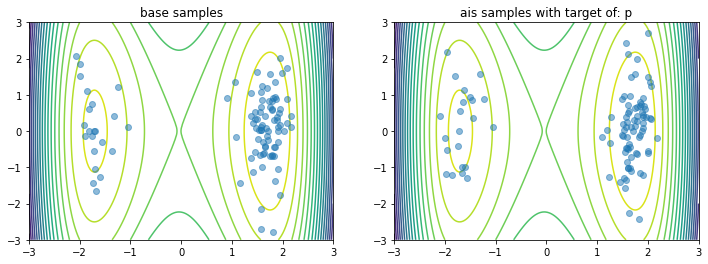

ess_ais: 0.9261462092399597, ess_base: 0.9222179651260376:  49%|█████████████████████████████████████████████████████████████▋                                                                | 49/100 [00:52<00:33,  1.54it/s]

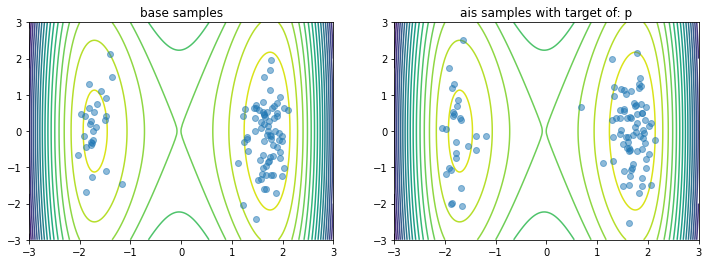

ess_ais: 0.9261462092399597, ess_base: 0.9222179651260376:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                | 74/100 [01:22<00:19,  1.33it/s]

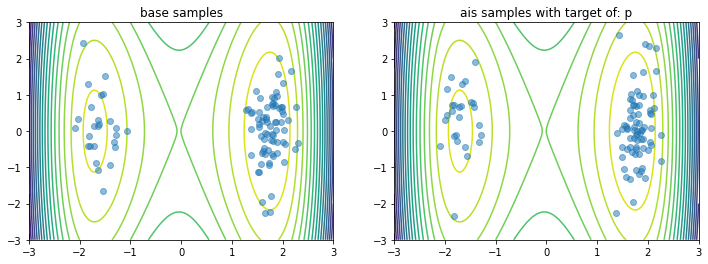

ess_ais: 0.9261462092399597, ess_base: 0.9222179651260376:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [01:53<00:00,  1.32it/s]

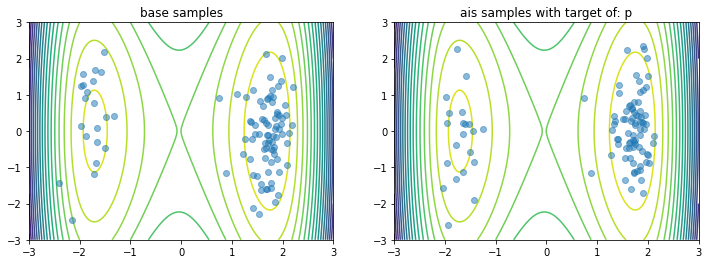

ess_ais: 0.9261462092399597, ess_base: 0.9222179651260376: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


In [14]:
target_samples_agent.run(n_iter=n_iter, batch_size=batch_size, n_plots=5, n_evals=n_evals, eval_batch_size=eval_batch_size)

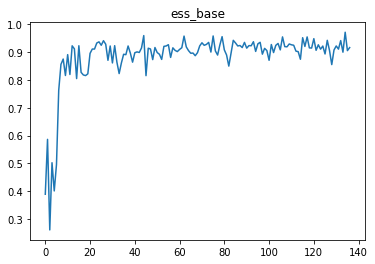

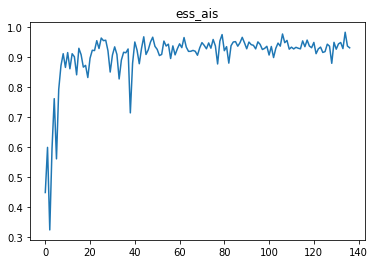

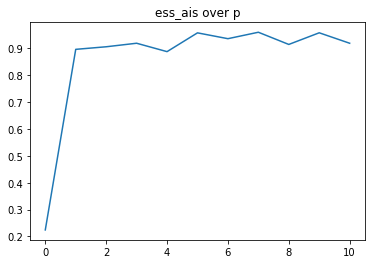

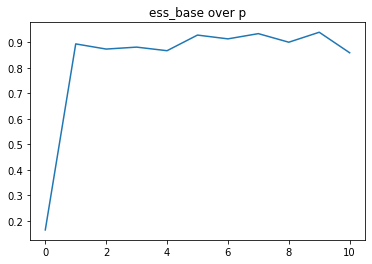

In [16]:
plt.plot(target_samples_agent.logger.history["ess_base"])
plt.title("ess_base")
plt.show()
plt.plot(target_samples_agent.logger.history["ess_ais"])
plt.title("ess_ais")
plt.show()
plt.plot(target_samples_agent.logger.history['eval_ess_ais'])
plt.title("ess_ais over p")
plt.show()
plt.plot(target_samples_agent.logger.history['eval_ess_flow'])
plt.title("ess_base over p")
plt.show()